In [1]:
cd /home/tkim/Academics/DistMEC/

/home/tkim/Academics/DistMEC


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pulp as lp
import itertools
import copy
from tqdm import tqdm, tqdm_notebook
import gurobipy as gp

In [18]:
def solve_optimization(UCB, C, L):
    U = UCB.shape[0]
    K = UCB.shape[1]
    
    m = gp.Model()
    
    x = m.addVars(U, K, vtype=gp.GRB.BINARY, name="x")
    y = m.addVars(U, K, name="y")
    
    # Define the objective function
    obj = gp.quicksum(x[u,k] * y[u,k] * UCB[u,k] for u in range(U) for k in range(K))
    m.setObjective(obj, gp.GRB.MAXIMIZE)
    
    for u in range(U):
        m.addConstr(gp.quicksum(x[u,k] for k in range(K)) <= 1)
        for k in range(K):
            m.addConstr(y[u,k] <= 1)
            m.addConstr(y[u,k] * (gp.quicksum(x[p,k] for p in range(U))) <= C[k]) # Adding small constant to avoid division by zero error
            m.addConstr(x[u,k] <= L[u,k])
    
    m.setParam("OutputFlag", 0)
    m.optimize()
    
    # Obtain Reward
    obj_val = m.objVal
    x_dec = np.array([[x[u,k].x for k in range(K)] for u in range(U)])
    
    del m, x, y, obj
    return x_dec, obj_val

def update_UCB(UCB, T_ka, rewards_sum, t):
    
    UCB_temp = np.zeros_like(UCB)
    U = UCB.shape[0]
    K = UCB.shape[1]
    
    mu_bar = np.zeros_like(UCB_temp)
    
    for u in range(U):
        for k in range(K):
            mu_bar[u,k] = rewards_sum[u,k] / T_ka[u,k]
            UCB_temp[u,k] = mu_bar[u,k] + np.sqrt(2 * np.log(t) / T_ka[u,k])
                
    return UCB_temp, mu_bar

def play_UCB(UCB, T_ka, rewards_sum, t, mu, x):
    
    U = UCB.shape[0]
    K = UCB.shape[1]
    
    # Update arm pull counts & Draw Rewards for all users
    for u in range(U):
        for k in range(K):
            T_ka[u,k] += x[u,k]
            rewards_sum[u,k] += x[u,k] * int(np.random.rand() < mu[u, k])
    
    UCB_temp, mu_bar = update_UCB(UCB, T_ka, rewards_sum, t)
    
    return UCB_temp, T_ka, rewards_sum, mu_bar

def update_L_random(U,K, num_select):
    L = np.zeros([U,K])
    for u in range(U):
        idx = np.random.choice(range(K), size=num_select, replace=False, p=None)
        for i in idx:
            L[u,i] = 1
    
    return L

def calculate_obj_val(x, B, C):
    U, K = x.shape
    obj_val = 0
    for u in range(U):
        for k in range(K):
            denom = 1e-5
            for u2 in range(U):
                denom += x[u2,k]
            obj_val += x[u,k] * B[u,k] * min(C[k]/denom, 1)
    return obj_val

In [19]:
# Setting up CMAB implementation
U = 6 # Number users
K = 6 # Number servers
T = 100
L_select = 4

mu = np.random.uniform(low=0.0, high=1.0, size=[U,K])
mu_bar = np.zeros_like(mu)
C = np.random.randint(low = 1, high=3, size=K, dtype=int)

UCB = np.ones_like(mu)
T_ka = np.ones_like(mu)
rewards_sum = np.ones([U,K]) # Just for calculating UCB idx
regret = np.zeros(T)

pbar = tqdm(total=T)

for t in range(T):
    # Obtain New Arm availability
    L = update_L_random(U,K,num_select=L_select)
    opt_x, opt_reward = solve_optimization(mu, C, L)
    lrn_x, _ = solve_optimization(UCB, C, L)
    lrn_reward = calculate_obj_val(lrn_x, mu, C)
    
    # calculate regert
    regret[t] = opt_reward - lrn_reward
    
    # Update UCB Learning
    UCB, T_ka, rewards_sum, mu_bar = play_UCB(UCB, T_ka, rewards_sum, t+1, mu, lrn_x)
    pbar.update(1)

# plot cumulative regert    
pbar.close()

100%|██████████| 100/100 [00:02<00:00, 47.78it/s]


Text(0.5,0,'Rounds')

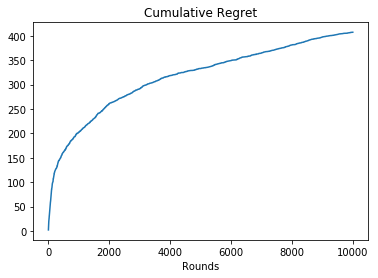

In [12]:
plt.plot(np.cumsum(regret))
plt.title("Cumulative Regret")
plt.xlabel("Rounds")

Text(0.5,0,'Rounds')

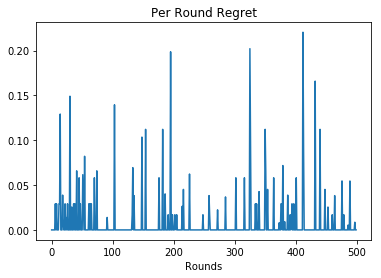

In [15]:
plt.plot(regret[-500:])
plt.title("Per Round Regret")
plt.xlabel("Rounds")